In [14]:
import matplotlib.pyplot as plt

from tabpfn.evaluation.baselines import tabular_baselines

import seaborn as sns
import pandas as pd
import numpy as np

from tabpfn.datasets import load_openml_list, open_cc_valid_dids, open_cc_dids
from tabpfn.evaluation.baselines.tabular_baselines import knn_metric, catboost_metric, transformer_metric, logistic_metric, xgb_metric, random_forest_metric, mlp_metric
from tabpfn.evaluation.tabular_evaluation import evaluate, eval_on_datasets
from tabpfn.evaluation import tabular_metrics
from tabpfn.prediction.tabpfn import TabPFNClassifier

In [2]:
%load_ext autoreload

%autoreload 2

# Datasets

In [3]:
from tabpfn.datasets import load_openml_list, open_cc_dids, open_cc_valid_dids, test_dids_classification

cc_valid_datasets_multiclass, cc_valid_datasets_multiclass_df = load_openml_list(open_cc_valid_dids, multiclass=True, shuffled=True, filter_for_nan=False, max_samples = 10000, num_feats=100, return_capped=True)


/home/azureuser/TabPFN/tabpfn/datasets/__init__.py:45: FutureWarning: Support for `output_format` of 'dict' will be removed in 0.15 and pandas dataframes will be returned instead. To ensure your code will continue to work, use `output_format`='dataframe'.
  openml_list = openml.datasets.list_datasets(dids)


Number of datasets: 149


/home/azureuser/TabPFN/tabpfn/datasets/__init__.py:8: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  dataset = openml.datasets.get_dataset(did)
/home/azureuser/TabPFN/tabpfn/datasets/__init__.py:9: FutureWarning: Support for `dataset_format='array'` will be removed in 0.15,start using `dataset_format='dataframe' to ensure your code will continue to work. You can use the dataframe's `to_numpy` function to continue using numpy arrays.
  X, y, categorical_indicator, attribute_names = dataset.get_data(
/home/azureuser/TabPFN/tabpfn/datasets/__init__.py:8: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all b

In [4]:
heart_h = [x for x in cc_valid_datasets_multiclass if x[0] == "heart-h"][0]
heart_h[1]

tensor([[52.,  1.,  1.,  ...,  1., nan, nan],
        [35.,  0.,  1.,  ..., nan, nan, nan],
        [39.,  1.,  3.,  ..., nan, nan, nan],
        ...,
        [36.,  1.,  3.,  ..., nan, nan, nan],
        [45.,  1.,  3.,  ..., nan, nan, nan],
        [58.,  1.,  2.,  ..., nan, nan, nan]])

In [5]:
cc_valid_datasets_multiclass_df['NumberOfInstances'] =  cc_valid_datasets_multiclass_df['NumberOfInstances'].astype(int)
cc_valid_datasets_multiclass_df['NumberOfFeatures'] =  cc_valid_datasets_multiclass_df['NumberOfFeatures'].astype(int)
cc_valid_datasets_multiclass_df['NumberOfClasses'] =  cc_valid_datasets_multiclass_df['NumberOfClasses'].astype(int)

print(cc_valid_datasets_multiclass_df[['did', 'name', 'NumberOfFeatures', 'NumberOfInstances', 'NumberOfClasses']].rename(columns={'NumberOfFeatures': "d", "NumberOfInstances":"n", "NumberOfClasses": "k"}).to_latex(index=False))

\begin{tabular}{rlrrr}
\toprule
did & name & d & n & k \\
\midrule
13 & breast-cancer & 10 & 286 & 2 \\
25 & colic & 27 & 368 & 2 \\
35 & dermatology & 35 & 366 & 6 \\
40 & sonar & 61 & 208 & 2 \\
41 & glass & 10 & 214 & 6 \\
43 & haberman & 4 & 306 & 2 \\
48 & tae & 6 & 151 & 3 \\
49 & heart-c & 14 & 303 & 2 \\
51 & heart-h & 14 & 294 & 2 \\
53 & heart-statlog & 14 & 270 & 2 \\
55 & hepatitis & 20 & 155 & 2 \\
56 & vote & 17 & 435 & 2 \\
59 & ionosphere & 35 & 351 & 2 \\
61 & iris & 5 & 150 & 3 \\
187 & wine & 14 & 178 & 3 \\
329 & hayes-roth & 5 & 160 & 3 \\
333 & monks-problems-1 & 7 & 556 & 2 \\
334 & monks-problems-2 & 7 & 601 & 2 \\
335 & monks-problems-3 & 7 & 554 & 2 \\
336 & SPECT & 23 & 267 & 2 \\
337 & SPECTF & 45 & 349 & 2 \\
338 & grub-damage & 9 & 155 & 4 \\
377 & synthetic_control & 61 & 600 & 6 \\
446 & prnn_crabs & 8 & 200 & 2 \\
450 & analcatdata_lawsuit & 5 & 264 & 2 \\
451 & irish & 6 & 500 & 2 \\
452 & analcatdata_broadwaymult & 8 & 285 & 7 \\
460 & analcatdata_rev

# Setting params

In [6]:
import os
eval_positions = [1000]
max_features = 100
n_samples = 2000
base_path = os.path.join('..')
overwrite = False
#max_times = [0.5, 1, 15, 30, 60, 60*5, 60*15, 60*60]
#max_times = [1, 15]
max_times = [1, 15, 30, 60, 60 * 5, 60 * 15, 60*60]
metric_used = tabular_metrics.auc_metric
task_type = 'multiclass'

In [7]:
from tabpfn.evaluation.baselines.distill_mlp import DistilledTabPFNMLP
from tabpfn.prediction.mothernet import PermutationsMeta, MotherNetClassifier
from functools import partial

# Baseline Evaluation
This section runs baselines and saves results locally.

In [8]:
!mkdir -p {base_path}/results
!mkdir -p {base_path}/results/tabular/
!mkdir -p {base_path}/results/tabular/multiclass/

In [9]:
#cc_valid_datasets_multiclass_df['isNumeric'] = (cc_valid_datasets_multiclass_df.NumberOfSymbolicFeatures == 1) & (cc_valid_datasets_multiclass_df.NumberOfInstancesWithMissingValues == 0) * (cc_valid_datasets_multiclass_df.NumberOfFeatures > 4)
#name_indexed_dataset = cc_valid_datasets_multiclass_df.set_index("name")

#numeric_valid_datasets = [ds for ds in cc_valid_datasets_multiclass if name_indexed_dataset.loc[ds[0]].isNumeric]
#len(numeric_valid_datasets)
len(cc_valid_datasets_multiclass)

149

In [10]:
max_times = [1, 5, 15, 60, 5 * 60, 15 * 60, 60* 60]
# these will all be evaluated on CPU because they are given as  callables, which is a weird way to do it.
clf_dict= {
    'knn': knn_metric,
    'rf_new_params': random_forest_metric,
    'xgb': xgb_metric,
    'logistic': logistic_metric,
    'mlp': mlp_metric}

results_baselines = [
    eval_on_datasets('multiclass', model, model_name, cc_valid_datasets_multiclass, eval_positions=eval_positions, max_times=max_times,
                     metric_used=metric_used, split_numbers=[1, 2, 3, 4, 5],
                     n_samples=n_samples, base_path=base_path)
    for model_name, model in clf_dict.items()
]

evaluating knn on cpu


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 620 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 2015 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 3954 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 4481 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 5215 out of 5215 | elapsed:   19.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


evaluating rf_new_params on cpu


[Parallel(n_jobs=-1)]: Done 177 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 2324 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 4104 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 5024 out of 5215 | elapsed:    2.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 5215 out of 5215 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


evaluating xgb on cpu


[Parallel(n_jobs=-1)]: Done 179 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 864 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 3713 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 4818 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 5215 out of 5215 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


evaluating logistic on cpu


[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 3728 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 4818 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 5215 out of 5215 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.2s


evaluating mlp on cpu


[Parallel(n_jobs=-1)]: Done 864 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 3721 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 4818 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 5215 out of 5215 | elapsed:    1.9s finished


In [11]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingClassifier
from tabpfn.prediction.mothernet import ShiftClassifier, EnsembleMeta, MotherNetClassifier

# transformers don't have max times
import warnings
max_times = [1]
#device = "cuda:1"
device = "cpu"


In [12]:

model_string = "defaults_k_aggregate_2_batch_128_onehot_classes_multiclass_02_10_2023_23_55_16"
tabpfn_mine =  TabPFNClassifier(device=device, model_string=model_string, epoch=82, N_ensemble_configurations=3)
#tabpfn_refactor = TabPFNClassifier(device=device, model_string="vanilla_lr0001_new_05_31_2023_23_16_43", epoch=200, N_ensemble_configurations=32)
#tabpfn_refactor_epoch_290 = TabPFNClassifier(device=device, model_string="vanilla_lr0001_new_05_31_2023_23_16_43", epoch=290, N_ensemble_configurations=32)

tabpfn_post_jan_refactor = TabPFNClassifier(device=device, model_string="tabpfn_1_gpu_01_05_2024_02_35_20", epoch=1100, N_ensemble_configurations=3)

distilled_tabpfn = DistilledTabPFNMLP(n_epochs=1000, device=device, hidden_size=128, n_layers=2, dropout_rate=.1, learning_rate=0.01, model_string=model_string, epoch=82, )
distilled_tabpfn_one_layer = make_pipeline(StandardScaler(),DistilledTabPFNMLP(n_epochs=1000, device=device, hidden_size=128, n_layers=1, dropout_rate=.1, learning_rate=0.01, model_string=model_string, epoch=82, ))
distilled_tabpfn_one_layer_no_dropout = make_pipeline(StandardScaler(),DistilledTabPFNMLP(n_epochs=1000, device=device, hidden_size=128, n_layers=1, dropout_rate=0, learning_rate=0.01, model_string=model_string, epoch=82, ))
distilled_tabpfn_two_layer_reproduce2 = make_pipeline(StandardScaler(), DistilledTabPFNMLP(n_epochs=1000, device=device, hidden_size=128, n_layers=2, dropout_rate=.1, learning_rate=0.01, model_string=model_string, epoch=82, ))
distilled_tabpfn_one_layer_512_no_dropout = make_pipeline(StandardScaler(),DistilledTabPFNMLP(n_epochs=1000, device=device, hidden_size=512, n_layers=1, learning_rate=0.001, model_string=model_string, epoch=82, ))
distilled_tabpfn_two_layer_512_no_dropout = make_pipeline(StandardScaler(),DistilledTabPFNMLP(n_epochs=1000, device=device, hidden_size=512, n_layers=2, learning_rate=0.001, model_string=model_string, epoch=82, ))

distilled_tabpfn_two_layer_reproduce_gpu = make_pipeline(StandardScaler(), DistilledTabPFNMLP(n_epochs=1000, device=device, hidden_size=128, n_layers=2, dropout_rate=.1, learning_rate=0.01, model_string=model_string, epoch=82, ))
distilled_tabpfn_two_layer_reproduce_gpu_ensemble_3 = make_pipeline(StandardScaler(), DistilledTabPFNMLP(n_epochs=1000, device=device, hidden_size=128, n_layers=2, dropout_rate=.1, learning_rate=0.01, model_string=model_string, epoch=82, N_ensemble_configurations=3))
distilled_tabpfn_two_layer_reproduce_cpu_ensemble_3 = make_pipeline(StandardScaler(), DistilledTabPFNMLP(n_epochs=1000, device="cpu", hidden_size=128, n_layers=2, dropout_rate=.1, learning_rate=0.01, model_string=model_string, epoch=82, N_ensemble_configurations=3))
new_model_string = "tabpfn_nooptimizer_emsize_512_nlayers_12_steps_2048_bs_32ada_lr_0.0001_1_gpu_07_24_2023_01_43_33"
distilled_tabpfn_two_layer_new = make_pipeline(StandardScaler(), DistilledTabPFNMLP(n_epochs=1000, device="cpu", hidden_size=128, n_layers=2, dropout_rate=.1, learning_rate=0.01, model_string=new_model_string, epoch=1650, N_ensemble_configurations=3))



mother_model_string = "models_diff/prior_diff_real_checkpointcontinue_hidden_128_embed_dim_1024_decoder_nhid_2048_nlayer12_lr0003_n_0_epoch_65.cpkt"
forward_mlp = PermutationsMeta(MotherNetClassifier(path=mother_model_string, device=device))
mothernet_new = PermutationsMeta(MotherNetClassifier(path='models_diff/prior_diff_real_checkpointcontinue_hidden_128_embed_dim_1024_decoder_nhid_2048_nlayer12_lr0003_n_0_epoch_on_exit.cpkt'))
mothernet_new_again = PermutationsMeta(MotherNetClassifier(path='models_diff/mothernet_from_scratch_again_06_28_2023_20_51_25_epoch_on_exit.cpkt'))

mothernet_big_model_string = "models_diff/prior_diff_real_checkpointwarm_start_depth_18_model_maker_lr0003_multiclass_05_30_2023_22_53_04_n_0_epoch_49.cpkt"
mothernet_big = PermutationsMeta(MotherNetClassifier(path=mothernet_big_model_string, device=device))

model_string_post_refactor = "models_diff/prior_diff_real_checkpointmothernet_from_scratch_lr0003_warm_start_continue2_multiclass_05_31_2023_19_21_34_n_0_epoch_94.cpkt"
mothernet_post_refactor = PermutationsMeta(MotherNetClassifier(path=model_string_post_refactor, device=device))

model_string_mothernet_small_batches = "models_diff/mothernet_512_everywhere_steps_1024_batch_16_07_02_2023_17_29_55_epoch_on_exit.cpkt"
mothernet_small_batches = PermutationsMeta(MotherNetClassifier(path=model_string_mothernet_small_batches, device=device))


model_string_old_reference_config = "reproduce_reference_config_06_02_2023_17_08_59"
old_reference_config = TabPFNClassifier(device=device, model_string=model_string_old_reference_config, epoch="on_exit", N_ensemble_configurations=32)
old_reference_config_epoch_290 = TabPFNClassifier(device=device, model_string=model_string_old_reference_config, epoch=290, N_ensemble_configurations=32)

model_string_reference_config_continue =  "reproduce_reference_config_continue_06_05_2023_17_45_06"
reference_config_continue = TabPFNClassifier(device=device, model_string=model_string_reference_config_continue, epoch="on_exit", N_ensemble_configurations=32)



model_string_reference_config_long = "reproduce_reference_config_try_again_800_epochs_06_07_2023_21_49_10"
reference_config_long = TabPFNClassifier(device=device, model_string=model_string_reference_config_long, epoch="on_exit", N_ensemble_configurations=32)

perceiver_long = MotherNetClassifier(path="models_diff/perceiver_output_128_emsize_512_nlayers_12_steps_1024_07_01_2023_17_56_04_epoch_690.cpkt", device=device)
perceiver_long_permutations = PermutationsMeta(perceiver_long)

model_string_newest_mlflow = "models_diff/mothernet_128_decoder_1024_emsize_512_nlayers_12_steps_1024_bs_32a_lr_0.0001_1_gpu_07_19_2023_04_54_38_epoch_1350.cpkt"
mothernet_mlflow_04_54_38 = PermutationsMeta(MotherNetClassifier(path=model_string_newest_mlflow, device=device))

model_string_newest_mlflow_1750 = "models_diff/mothernet_128_decoder_1024_emsize_512_nlayers_12_steps_1024_bs_32a_lr_0.0001_1_gpu_07_19_2023_04_54_38_epoch_1750.cpkt"
mothernet_mlflow_04_54_38_e1750 = PermutationsMeta(MotherNetClassifier(path=model_string_newest_mlflow_1750, device=device))
mothernet_mlflow_04_54_38_e1750_ensemble = EnsembleMeta(MotherNetClassifier(path=model_string_newest_mlflow_1750, device=device))


#mothernet_tabpfn_preprocessing =  TabPFNClassifier(device=device, model_string="mothernet_128_decoder_1024_emsize_512_nlayers_12_steps_1024_bs_32a_lr_0.0001_1_gpu_07_19_2023_04_54_38", epoch="1350", N_ensemble_configurations=32)

#mothernet_new_old_tabpfn_preprocessing =  TabPFNClassifier(device=device, model_string="prior_diff_real_checkpointcontinue_hidden_128_embed_dim_1024_decoder_nhid_2048_nlayer12_lr0003_n_0", epoch="on_exit", N_ensemble_configurations=32)
#mothernet_new_old_ensemble =  EnsembleMeta(MotherNetClassifier(device=device, path="models_diff/prior_diff_real_checkpointcontinue_hidden_128_embed_dim_1024_decoder_nhid_2048_nlayer12_lr0003_n_0_epoch_on_exit.cpkt"), n_estimators=32)

#mothernet_1750_tabpfn_preprocessing =  TabPFNClassifier(device=device, model_string="mothernet_128_decoder_1024_emsize_512_nlayers_12_steps_1024_bs_32a_lr_0.0001_1_gpu_07_19_2023_04_54_38", epoch="1750", N_ensemble_configurations=32)


perceiver_16_19_18_ensemble =  EnsembleMeta(MotherNetClassifier(device=device, path="models_diff/perceiver_128_emsize_512_nlayers_12_steps_4096_batch_64_lr_3e-05_one_gpu_07_11_2023_16_19_18_epoch_1120.cpkt"), n_estimators=32)

mlflow_validate_str = "tabpfn_128_decoder_1024_emsize_512_nlayers_12_steps_1024_bs_8ada_lr_3e-05_1_gpu_07_21_2023_21_58_32"
mlflow_validate_tabpfn = TabPFNClassifier(device=device, model_string=mlflow_validate_str, epoch="1470", N_ensemble_configurations=32)

#mother_of_ensembles = BaggingClassifier(PermutationsMeta(MotherNetClassifier(path=mother_model_string)), max_features=.8, max_samples=.8)
#mother_of_ensembles_again = BaggingClassifier(PermutationsMeta(MotherNetClassifier(path=mother_model_string)), max_features=.5, max_samples=.5)
forward_mlp_scaled = make_pipeline(StandardScaler(), forward_mlp)
distilled_tabpfn_scaled = make_pipeline(StandardScaler(), distilled_tabpfn)


#new_tabpfn_long_e1020 = TabPFNClassifier(device=device, model_string="tabpfn__emsize_512_nlayers_12_steps_2048_bs_32ada_lr_0.0001_1_gpu_07_24_2023_01_43_33", epoch="1020", N_ensemble_configurations=32)
new_tabpfn_long_e1650_ensemble32 = TabPFNClassifier(device=device, model_string="tabpfn__emsize_512_nlayers_12_steps_2048_bs_32ada_lr_0.0001_1_gpu_07_24_2023_01_43_33", epoch="1650", N_ensemble_configurations=32)
new_tabpfn_long_e1650_ensemble3 = TabPFNClassifier(device=device, model_string="tabpfn_nooptimizer_emsize_512_nlayers_12_steps_2048_bs_32ada_lr_0.0001_1_gpu_07_24_2023_01_43_33", epoch="1650", N_ensemble_configurations=3)

# large batchsize large learning rate
mothernet_old_config_repro_20_10_21_ensemble = EnsembleMeta(MotherNetClassifier(path="models_diff/mothernet_128_decoder_2048_emsize_512_nlayers_12_steps_512_bs_8192_lr_0.0003_1_gpu_07_28_2023_20_10_21_epoch_2000.cpkt", device=device))
# small batchsize small learning rate
mothernet_new_config_04_14_37_ensemble_e1390 = EnsembleMeta(MotherNetClassifier(path="models_diff/mothernet_128_decoder_2048_emsize_512_nlayers_12_steps_8192_bs_8ada_lr_3e-05_1_gpu_07_26_2023_04_14_37_epoch_1390.cpkt", device=device)) 
mothernet_new_config_04_14_37_ensemble_e1520 = EnsembleMeta(MotherNetClassifier(path="models_diff/mothernet_128_decoder_2048_emsize_512_nlayers_12_steps_8192_bs_8ada_lr_3e-05_1_gpu_07_26_2023_04_14_37_epoch_1520.cpkt", device=device)) 

mothernet_01_07_16_e1560 = EnsembleMeta(MotherNetClassifier(path="models_diff/mothernet_128_decoder_2048_emsize_512_nlayers_12_steps_8192_bs_8ada_lr_3e-05_1_gpu_07_26_2023_04_14_37_continue_08_12_2023_01_07_16_epoch_1560.cpkt", device=device))
mothernet_21_29_51_e5610 = EnsembleMeta(MotherNetClassifier(path="models_diff/mn_n1024_E8000_1_gpu_08_01_2023_21_29_51_epoch_5610.cpkt", device=device))

low_rank_48_19 = EnsembleMeta(MotherNetClassifier(path="models_diff/mn_n1024_L2_W128_P512_1_gpu_08_03_2023_03_48_19_epoch_on_exit.cpkt", device=device))
mothernet_L2_18_33_e780 = EnsembleMeta(MotherNetClassifier(path="models_diff/mothernet_128_decoder_2048_emsize_512_nlayers_12_steps_8192_bs_8ada_lr_3e-05_1_gpu_07_31_2023_23_18_33_epoch_780.cpkt", device=device))

mothernet_15_46_11_e120 =  EnsembleMeta(MotherNetClassifier(path="models_diff/mn_d1024_H2048_l1e-06_b32_noprenormTrue_1_gpu_warm_08_13_2023_15_46_11_epoch_130.cpkt", device=device))
tabpfn_21_43_17_e760 =  TabPFNClassifier(model_string="tabpfn_n512_l1e-05_b32_mtabpfn_noprenormTrue_1_gpu_warm_08_11_2023_21_43_17", device=device, epoch=760, N_ensemble_configurations=32)
mothernet_01_07_16_e1720 = EnsembleMeta(MotherNetClassifier(path="models_diff/mothernet_128_decoder_2048_emsize_512_nlayers_12_steps_8192_bs_8ada_lr_3e-05_1_gpu_07_26_2023_04_14_37_continue_08_12_2023_01_07_16_epoch_1720.cpkt", device=device))
mothernet_01_07_16_e1720_gpu = EnsembleMeta(MotherNetClassifier(path="models_diff/mothernet_128_decoder_2048_emsize_512_nlayers_12_steps_8192_bs_8ada_lr_3e-05_1_gpu_07_26_2023_04_14_37_continue_08_12_2023_01_07_16_epoch_1720.cpkt", device=device))
mothernet_01_07_16_e1720_gpu_ensemble3 = EnsembleMeta(MotherNetClassifier(path="models_diff/mothernet_128_decoder_2048_emsize_512_nlayers_12_steps_8192_bs_8ada_lr_3e-05_1_gpu_07_26_2023_04_14_37_continue_08_12_2023_01_07_16_epoch_1720.cpkt", device=device), n_estimators=3)
mothernet_01_07_16_e1720_cpu_ensemble3 = EnsembleMeta(MotherNetClassifier(path="models_diff/mothernet_128_decoder_2048_emsize_512_nlayers_12_steps_8192_bs_8ada_lr_3e-05_1_gpu_07_26_2023_04_14_37_continue_08_12_2023_01_07_16_epoch_1720.cpkt", device="cpu"), n_estimators=3)
mothernet_01_07_16_e1720_gpu_ensemble3_gpu_inference = EnsembleMeta(MotherNetClassifier(path="models_diff/mothernet_128_decoder_2048_emsize_512_nlayers_12_steps_8192_bs_8ada_lr_3e-05_1_gpu_07_26_2023_04_14_37_continue_08_12_2023_01_07_16_epoch_1720.cpkt", device=device, inference_device=device), n_estimators=3)
mothernet_05_25_46_e5900 = EnsembleMeta(MotherNetClassifier(path="models_diff/mn_n1024_E8000_d2048_H4096_L2_W128_P512_1_gpu_08_06_2023_05_25_46_epoch_5900.cpkt", device=device))
mothernet_01_07_16_e1720_cpu_ensemble32 = EnsembleMeta(MotherNetClassifier(path="models_diff/mothernet_128_decoder_2048_emsize_512_nlayers_12_steps_8192_bs_8ada_lr_3e-05_1_gpu_07_26_2023_04_14_37_continue_08_12_2023_01_07_16_epoch_1720.cpkt", device="cpu"), n_estimators=32)


#mothernet_L2_W128_05_25_46_e6550 = EnsembleMeta(MotherNetClassifier(path="models_diff/mn_n1024_E8000_d2048_H4096_L2_W128_P512_1_gpu_08_06_2023_05_25_46_epoch_6550.cpkt", device=device))
mothernet_L2_W128_05_25_46_e7480 = EnsembleMeta(MotherNetClassifier(path="models_diff/mn_n1024_E8000_d2048_H4096_L2_W128_P512_1_gpu_08_06_2023_05_25_46_epoch_7480.cpkt", device=device))

mothernet_16_28_11_e1870_ensemble32 = EnsembleMeta(MotherNetClassifier(path="models_diff/mn_d2048_H4096_1_gpu_08_04_2023_16_28_11_epoch_1870_kept_for_eval.cpkt", device=device), n_estimators=32)
mothernet_16_28_11_e1870_ensemble3 = EnsembleMeta(MotherNetClassifier(path="models_diff/mn_d2048_H4096_1_gpu_08_04_2023_16_28_11_epoch_1870_kept_for_eval.cpkt", device=device), n_estimators=3)
mothernet_16_28_11_e1980_ensemble32 = EnsembleMeta(MotherNetClassifier(path="models_diff/mn_d2048_H4096_1_gpu_08_04_2023_16_28_11_epoch_1980_kept_for_eval.cpkt", device=device), n_estimators=32)
mothernet_16_28_11_e1980_ensemble3 = EnsembleMeta(MotherNetClassifier(path="models_diff/mn_d2048_H4096_1_gpu_08_04_2023_16_28_11_epoch_1980_kept_for_eval.cpkt", device=device), n_estimators=3)

mothernet_06_03_16_e3130_ensemble3 = EnsembleMeta(MotherNetClassifier(path="models_diff/mn_E4000_L2_W32_1_gpu_08_06_2023_06_03_16_epoch_3130.cpkt", device=device), n_estimators=3)
mothernet_06_03_16_e3130_ensemble32 = EnsembleMeta(MotherNetClassifier(path="models_diff/mn_E4000_L2_W32_1_gpu_08_06_2023_06_03_16_epoch_3130.cpkt", device=device), n_estimators=32)
mothernet_06_03_16_e3900_ensemble3 = EnsembleMeta(MotherNetClassifier(path="models_diff/mn_E4000_L2_W32_1_gpu_08_06_2023_06_03_16_epoch_3900.cpkt", device=device), n_estimators=3)

mothernet_21_46_25_e3140 = MotherNetClassifier(path="models_diff/mn_d2048_H4096_L2_W32_P512_1_gpu_warm_08_25_2023_21_46_25_epoch_3140.cpkt", device=device)

# mothernet_21_46_25_e3140_ensemble3_no_power = EnsembleMeta(MotherNetClassifier(path="models_diff/mn_d2048_H4096_L2_W32_P512_1_gpu_warm_08_25_2023_21_46_25_epoch_3140.cpkt", device=device), n_estimators=3, power=False)
#mothernet_21_46_25_e3140_ensemble3_no_label_shift = EnsembleMeta(MotherNetClassifier(path="models_diff/mn_d2048_H4096_L2_W32_P512_1_gpu_warm_08_25_2023_21_46_25_epoch_3140.cpkt", device=device), n_estimators=3, label_shift=False)
#mothernet_21_46_25_e3140_ensemble3_no_feature_shift = EnsembleMeta(MotherNetClassifier(path="models_diff/mn_d2048_H4096_L2_W32_P512_1_gpu_warm_08_25_2023_21_46_25_epoch_3140.cpkt", device=device), n_estimators=3, feature_shift=False)

mothernet_21_46_25_e3140_ensemble3 = EnsembleMeta(MotherNetClassifier(path="models_diff/mn_d2048_H4096_L2_W32_P512_1_gpu_warm_08_25_2023_21_46_25_epoch_3140.cpkt", device=device), n_estimators=3)
mothernet_21_46_25_e3140_ensemble32 = EnsembleMeta(MotherNetClassifier(path="models_diff/mn_d2048_H4096_L2_W32_P512_1_gpu_warm_08_25_2023_21_46_25_epoch_3140.cpkt", device=device), n_estimators=32)

mothernet_21_46_25_3940_ensemble3 = EnsembleMeta(MotherNetClassifier(path="models_diff/mn_d2048_H4096_L2_W32_P512_1_gpu_warm_08_25_2023_21_46_25_epoch_3940_no_optimizer.pickle", device=device), n_estimators=3)

mothernet_02_00_36_3320_ensemble3 = EnsembleMeta(MotherNetClassifier(path="models_diff/mn_b16_ATrue_L2_W32_reducelronspikeTrue_spiketolerance8_1_gpu_10_15_2023_15_53_47_continue_11_08_2023_14_37_42_continue_11_10_2023_02_00_36_epoch_3320_nooptimizer.cpkt", device=device), n_estimators=3)


#mothernet_14_40_26_e720_ensemble3 = EnsembleMeta(MotherNetClassifier(path="models_diff/mn_d2048_H4096_l1e-06_b128_1_gpu_warm_08_27_2023_14_40_26_epoch_720.ckt", device=device), n_estimators=3)

# actually accidentally trained with false due to bug, even if config says true
# reference_config_long.model.efficient_eval_masking = False
from hyperfast import HyperFastClassifier
hf = HyperFastClassifier(device=device)
hf.seed = 0
clf_dict= {
             'transformer_bug_fix1213': transformer_metric,
            'transformer_gpu_timing': TabPFNClassifier(device=device, N_ensemble_configurations=3),
              # 'tabpfn_mine': partial(transformer_metric, classifier=tabpfn_mine),
             #  'tabpfn_post_mlflow': partial(transformer_metric, classifier=mlflow_validate_tabpfn),
          
        'mothernet_01_07_16_e1720_cpu_ensemble3_prescaling': mothernet_01_07_16_e1720_cpu_ensemble3,

    'distilled_tabpfn_two_layer_reproduce_gpu_ensemble_3_fixed': distilled_tabpfn_two_layer_reproduce_gpu_ensemble_3,
    #'mothernet_01_07_16_e1720_gpu_ensemble3_gpu_inference_fixed': mothernet_01_07_16_e1720_gpu_ensemble3_gpu_inference,
      #  'mothernet_05_25_46_e5900': partial(transformer_metric, classifier=mothernet_05_25_46_e5900),
    #'mothernet_L2_W128_05_25_46_e6550': mothernet_L2_W128_05_25_46_e6550,
    #'mothernet_L2_W128_05_25_46_e7480': mothernet_L2_W128_05_25_46_e7480,
    #'mothernet_01_07_16_e1720_cpu_ensemble32': mothernet_01_07_16_e1720_cpu_ensemble32,
##   'new_tabpfn_long_e1650_ensemble32': new_tabpfn_long_e1650_ensemble32,
##    'new_tabpfn_long_e1650_ensemble3': new_tabpfn_long_e1650_ensemble3,
    'new_tabpfn_long_e1650_ensemble3_bug_fix1213': new_tabpfn_long_e1650_ensemble3,

    'new_tabpfn_long_e1650_ensemble3_onehot': partial(transformer_metric, classifier=new_tabpfn_long_e1650_ensemble3, onehot=True),
        'new_tabpfn_long_e1650_ensemble3_onehot_fix1213': partial(transformer_metric, classifier=new_tabpfn_long_e1650_ensemble3, onehot=True),
        'new_tabpfn_long_e1650_ensemble3_onehot_fix1213_rerun_jan': partial(transformer_metric, classifier=new_tabpfn_long_e1650_ensemble3, onehot=True),


   # 'new_tabpfn_long_e1650_ensemble3_onehot_again': partial(transformer_metric, classifier=new_tabpfn_long_e1650_ensemble3, onehot=True),


    #'new_tabpfn_long_e1020': new_tabpfn_long_e1020,
    #'mothernet_16_28_11_e1870_ensemble32': mothernet_16_28_11_e1870_ensemble32,
    #'mothernet_16_28_11_e1870_ensemble3': mothernet_16_28_11_e1870_ensemble3,
    #'mothernet_16_28_11_e1980_ensemble32': mothernet_16_28_11_e1980_ensemble32,
    #'mothernet_16_28_11_e1980_ensemble3': mothernet_16_28_11_e1980_ensemble3,
    #'mothernet_06_03_16_e3130_ensemble3': mothernet_06_03_16_e3130_ensemble3,
    #'mothernet_06_03_16_e3130_ensemble32': mothernet_06_03_16_e3130_ensemble32,
    #'mothernet_06_03_16_e3900_ensemble3': mothernet_06_03_16_e3900_ensemble3,
    #'mothernet_14_40_26_e720_ensemble3': mothernet_14_40_26_e720_ensemble3
##    'mothernet_21_46_25_e3140_ensemble3': mothernet_21_46_25_e3140_ensemble3,
##    'mothernet_21_46_25_e3140_ensemble32': mothernet_21_46_25_e3140_ensemble32,
##    'mothernet_02_00_36_3320_ensemble3': mothernet_02_00_36_3320_ensemble3,
    #'mothernet_21_46_25_e3140_ensemble3_no_power': mothernet_21_46_25_e3140_ensemble3_no_power,
    #'mothernet_21_46_25_e3140_ensemble3_no_label_shift': mothernet_21_46_25_e3140_ensemble3_no_label_shift,
    #'mothernet_21_46_25_e3140_ensemble3_no_feature_shift': mothernet_21_46_25_e3140_ensemble3_no_feature_shift,
   # 'mothernet_21_46_25_3940_ensemble3': mothernet_21_46_25_3940_ensemble3,
    'mothernet_21_46_25_3940_ensemble3_onehot': partial(transformer_metric, classifier=mothernet_21_46_25_3940_ensemble3, onehot=True),
  #  'mothernet_21_46_25_3940_ensemble3_onehot_again': partial(transformer_metric, classifier=mothernet_21_46_25_3940_ensemble3, onehot=True),
        #'distilled_tabpfn_two_layer_reproduce_gpu_ensemble_3_fixed_redo': distilled_tabpfn_two_layer_reproduce_gpu_ensemble_3,
    #'distilled_tabpfn_new': distilled_tabpfn_two_layer_new,
    'tabpfn_post_jan_refactor': tabpfn_post_jan_refactor,

    #'flaml_zero_shot': flaml_lgbm_metric,
    #'flaml_zero_shot_no_preprocess_pr': flaml_lgbm_metric,


                  }
results_transformers = [
    eval_on_datasets('multiclass', model, model_name, cc_valid_datasets_multiclass, eval_positions=eval_positions, max_times=max_times,
                     metric_used=metric_used, split_numbers=[1, 2, 3, 4, 5],
                     n_samples=n_samples, base_path=base_path, overwrite=False, n_jobs=-1)
    for model_name, model in clf_dict.items()
]

Loading model from hyperfast.ckpt...
Model loaded from hyperfast.ckpt
evaluating transformer_bug_fix1213 on cpu


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done 175 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 745 out of 745 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


evaluating transformer_gpu_timing on cpu


[Parallel(n_jobs=-1)]: Done 177 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 745 out of 745 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.2s


evaluating mothernet_01_07_16_e1720_cpu_ensemble3_prescaling on cpu


[Parallel(n_jobs=-1)]: Done 745 out of 745 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


evaluating distilled_tabpfn_two_layer_reproduce_gpu_ensemble_3_fixed on cpu


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 554 out of 745 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 745 out of 745 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


evaluating new_tabpfn_long_e1650_ensemble3_bug_fix1213 on cpu


[Parallel(n_jobs=-1)]: Done 175 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 745 out of 745 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done 177 tasks      | elapsed:    0.2s


evaluating new_tabpfn_long_e1650_ensemble3_onehot on cpu


[Parallel(n_jobs=-1)]: Done 745 out of 745 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


evaluating new_tabpfn_long_e1650_ensemble3_onehot_fix1213 on cpu


[Parallel(n_jobs=-1)]: Done 177 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 745 out of 745 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


evaluating new_tabpfn_long_e1650_ensemble3_onehot_fix1213_rerun_jan on cpu


[Parallel(n_jobs=-1)]: Done 177 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 554 out of 745 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 745 out of 745 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


evaluating mothernet_21_46_25_3940_ensemble3_onehot on cpu


[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 554 out of 745 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 745 out of 745 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


evaluating tabpfn_post_jan_refactor on cpu


[Parallel(n_jobs=-1)]: Done 175 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 554 out of 745 | elapsed:    4.7s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done 745 out of 745 | elapsed:   13.9s finished


In [15]:
flat_results = []
for per_dataset in results_baselines + results_transformers:
    for result in per_dataset:
        row = {}
        for key in ['dataset', 'model', 'mean_metric', 'split', 'max_time']:
            row[key] = result[key]
        best_configs_key, = [k for k in result.keys() if "best_configs" in k]
        if result[best_configs_key][0] is not None:
            row.update(result[best_configs_key][0])
        row['mean_metric'] = float(row["mean_metric"].numpy())
        flat_results.append(row)

results_df = pd.DataFrame(flat_results)

In [16]:
results_df

,dataset,model,mean_metric,split,max_time,best,fit_time,inference_time
0,breast-cancer,knn,0.661028,1,1,{'n_neighbors': 13},0.000223,0.001148
1,breast-cancer,knn,0.687982,2,1,{'n_neighbors': 13},0.000218,0.001148
2,breast-cancer,knn,0.639348,3,1,{'n_neighbors': 14},0.000214,0.001040
3,breast-cancer,knn,0.697394,4,1,{'n_neighbors': 14},0.000223,0.001092
4,breast-cancer,knn,0.687948,5,1,{'n_neighbors': 11},0.000226,0.001065
...,...,...,...,...,...,...,...,...
33520,titanic,tabpfn_post_jan_refactor,0.875887,1,1,NaN,0.001419,4.122384
33521,titanic,tabpfn_post_jan_refactor,0.869552,2,1,NaN,0.001017,2.787853
33522,titanic,tabpfn_post_jan_refactor,0.875486,3,1,NaN,0.001210,2.701545
33523,titanic,tabpfn_post_jan_refactor,0.884738,4,1,NaN,0.000899,3.637712


In [17]:
def remove_device_from_frame(df):    
    res = df.copy()
    res = res[~res.model.str.contains("CPU")]
    res['model'] = res['model'].str.replace(" GPU", "")
    return res

In [18]:
import pickle
with open("results_validation_post_refactor.pickle", "wb") as f:
    pickle.dump(results_baselines + results_transformers, f)

In [19]:
results_df.model.unique()

array(['knn', 'rf_new_params', 'xgb', 'logistic', 'mlp',
       'transformer_bug_fix1213', 'transformer_gpu_timing',
       'mothernet_01_07_16_e1720_cpu_ensemble3_prescaling',
       'distilled_tabpfn_two_layer_reproduce_gpu_ensemble_3_fixed',
       'new_tabpfn_long_e1650_ensemble3_bug_fix1213',
       'new_tabpfn_long_e1650_ensemble3_onehot',
       'new_tabpfn_long_e1650_ensemble3_onehot_fix1213',
       'new_tabpfn_long_e1650_ensemble3_onehot_fix1213_rerun_jan',
       'mothernet_21_46_25_3940_ensemble3_onehot',
       'tabpfn_post_jan_refactor'], dtype=object)

In [20]:
results_df.to_csv("results_validation_post_refactor.csv")

In [21]:
remove_device_from_frame(results_df).to_csv("results_valid_1213.csv")

In [22]:
results_df['model'] = results_df.model.replace({'knn': "KNN", 'rf_new_params': 'RF', 'mlp': "MLP",'distilled_tabpfn_two_layer_reproduce_gpu_ensemble_3_fixed': 'MLP-Distill GPU', 'xgb':'XGBoost', 'logistic': 'LogReg', 'distilled_tabpfn_two_layer_reproduce_cpu_ensemble_3':'MLP-Distill CPU', 'mothernet_21_46_25_3940_ensemble3_onehot': 'MotherNet', 'transformer_bug_fix1213': 'TabPFN (Hollmann)', 'new_tabpfn_long_e1650_ensemble3_bug_fix1213': 'TabPFN (ours)'})
#results_df = results_df[~(results_df.model.str.contains("_"))]

In [23]:
remove_device_from_frame(results_df).to_csv("results_valid_1213.csv")

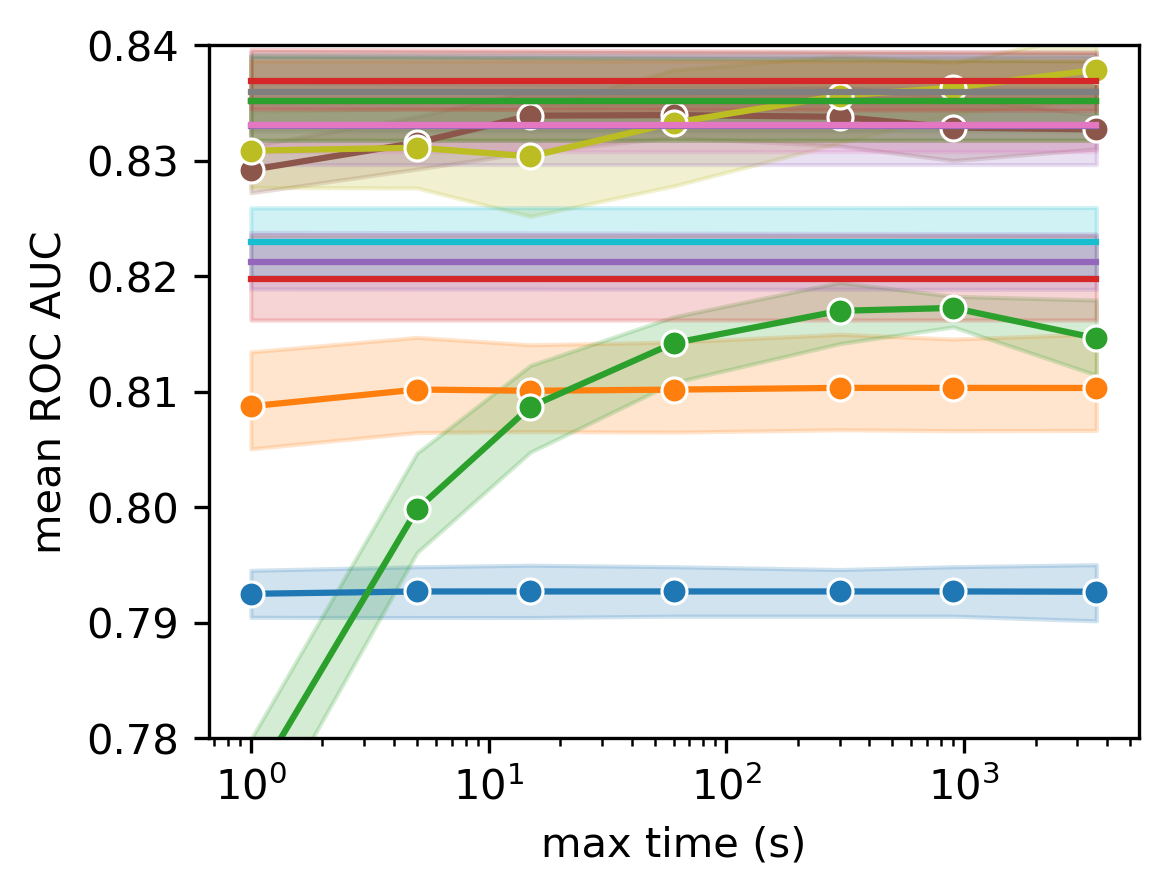

In [26]:
plt.figure(figsize=(4, 3), dpi=300)

compare_splits = remove_device_from_frame(results_df.groupby(["model", "split", "max_time"])['mean_metric'].mean().reset_index())

import seaborn as sns
varies_over_time = ['KNN', 'XGBoost', 'RF', 'MLP', 'KNN', 'LogReg', ]
compare_splits_varies = compare_splits[compare_splits.model.isin(varies_over_time)]
compare_splits_fixed = compare_splits[~compare_splits.model.isin(varies_over_time)]
all_models = compare_splits.model.unique()
color_palette = sns.color_palette(n_colors=len(all_models))
color_mapping = dict(zip(all_models, color_palette))

ax = sns.lineplot(data=compare_splits_varies, x="max_time", y="mean_metric", hue="model",  marker="o", palette=color_mapping)

compare_splits_fixed_dummy = compare_splits_fixed.copy()
compare_splits_fixed_dummy['max_time'] = compare_splits_varies.max_time.max()
sns.lineplot(data=pd.concat([compare_splits_fixed, compare_splits_fixed_dummy]),
             x="max_time", y="mean_metric", hue="model", ax=ax, palette=color_mapping)
ax.set_xscale("log")
plt.legend(loc=(1.1 , .3))
ax.set_ylim(0.78, 0.84)
ax.set_ylabel("mean ROC AUC")
ax.set_xlabel("max time (s)")
legend = ax.get_legend()
legend.remove()
plt.savefig("../figures/mean_auc_over_time_validation.pdf", bbox_inches="tight")

In [27]:
compare_splits_varies_last = compare_splits_varies[compare_splits_varies.max_time == compare_splits_varies.max_time.max()]

/tmp/ipykernel_1706546/3345411007.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=pd.concat([compare_splits_fixed, compare_splits_varies_last]), y="model", x="mean_metric", order=order, palette=color_mapping, ax=plt.gca())


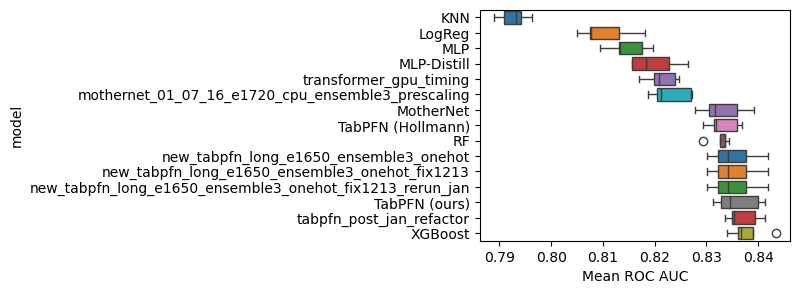

In [28]:
plt.figure(figsize=(4, 3))

order = pd.concat([compare_splits_fixed, compare_splits_varies_last]).groupby("model").median("mean_metric").sort_values("mean_metric").index
sns.boxplot(data=pd.concat([compare_splits_fixed, compare_splits_varies_last]), y="model", x="mean_metric", order=order, palette=color_mapping, ax=plt.gca())
plt.xlabel("Mean ROC AUC")
plt.savefig("../figures/mean_roc_auc_validation.pdf", dpi=300, bbox_inches="tight")

In [29]:
average_over_splits = results_df.groupby(["dataset", "model", "max_time"])[["mean_metric", "fit_time", "inference_time"]].mean().reset_index()

In [30]:
best_tuned = average_over_splits[average_over_splits.max_time == average_over_splits.max_time.max()]
untuned = average_over_splits[~average_over_splits.model.isin(best_tuned.model.unique())]
combined_best = pd.concat([best_tuned, untuned])

In [31]:
combined_best

,dataset,model,max_time,mean_metric,fit_time,inference_time
6,Australian,KNN,3600,0.906615,0.000251,0.005291
13,Australian,LogReg,3600,0.914737,0.003780,0.000171
20,Australian,MLP,3600,0.911973,0.888753,0.001075
29,Australian,RF,3600,0.928492,0.136285,0.101421
38,Australian,XGBoost,3600,0.929038,1.126681,0.008836
...,...,...,...,...,...,...
6700,xd6,new_tabpfn_long_e1650_ensemble3_onehot,1,1.000000,0.000561,3.482810
6701,xd6,new_tabpfn_long_e1650_ensemble3_onehot_fix1213,1,1.000000,0.000401,3.572037
6702,xd6,new_tabpfn_long_e1650_ensemble3_onehot_fix1213...,1,1.000000,0.000598,3.331648
6703,xd6,tabpfn_post_jan_refactor,1,0.999920,0.001254,4.292733


/anaconda/envs/tabpfn_testing_environment/lib/python3.11/site-packages/autorank/_util.py:432: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if abs(sorted_ranks[i] - sorted_ranks[j]) <= critical_difference:
/home/azureuser/TabPFN/tabpfn/evaluation/cd_plot_new/cd_plot_code.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plot_line([(rankpos(sorted_ranks[i]), cline), (rankpos(sorted_ranks[i]), chei), (textspace - 0.1, chei)], linewidth=linewidth)
/home/azureuser/TabPFN/tabpfn/evaluation/cd_plot_new/cd_plot_code.py:80: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, in

RankResult(rankdf=                                                     meanrank    median  \
TabPFN (ours)                                        5.765101 -0.897725   
new_tabpfn_long_e1650_ensemble3_onehot_fix1213_...   5.973154 -0.895690   
new_tabpfn_long_e1650_ensemble3_onehot               6.030201 -0.895690   
new_tabpfn_long_e1650_ensemble3_onehot_fix1213       6.030201 -0.895690   
tabpfn_post_jan_refactor                             6.258389 -0.896199   
TabPFN (Hollmann)                                    7.493289 -0.884264   
MotherNet                                            7.597315 -0.897800   
XGBoost                                              7.848993 -0.900142   
transformer_gpu_timing                               8.278523 -0.864987   
RF                                                   8.469799 -0.884138   
MLP-Distill                                          8.513423 -0.863665   
mothernet_01_07_16_e1720_cpu_ensemble3_prescaling    8.667785 -0.849986   
LogReg 

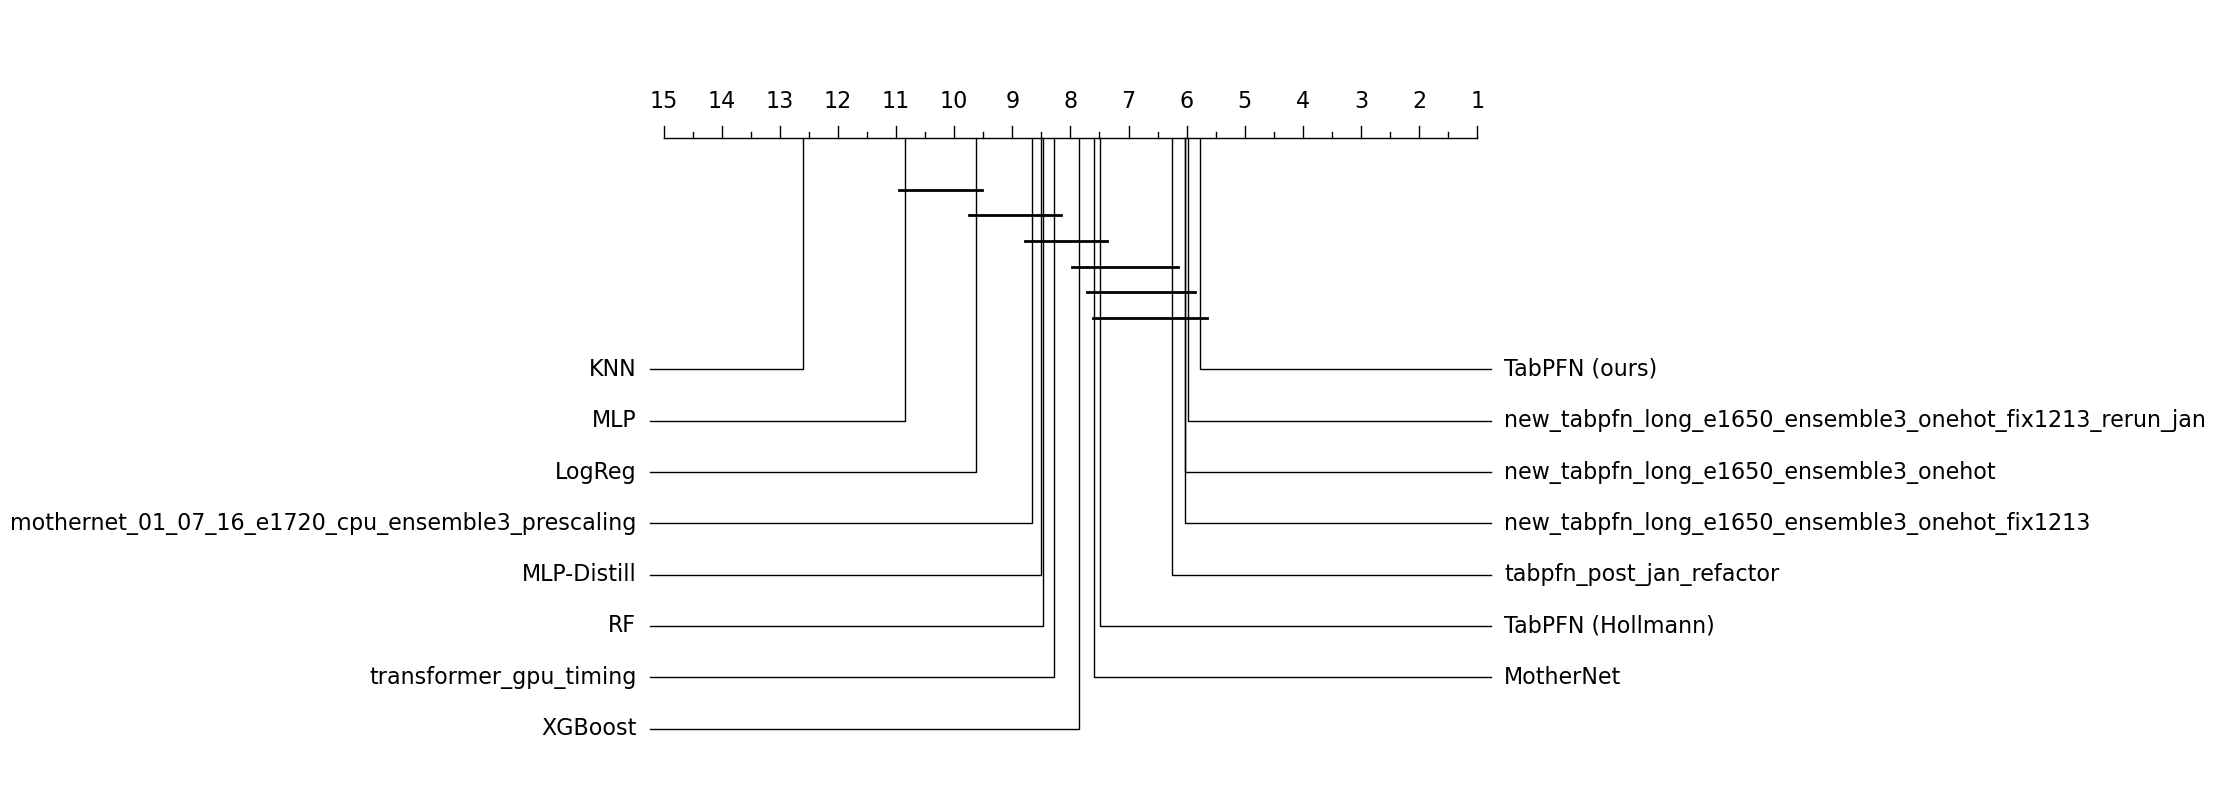

In [35]:
from tabpfn.evaluation.cd_plot_new.cd_plot_code import cd_evaluation
# plt.figure(figsize=(4, 2), dpi=300)
pivoted_for_cd = remove_device_from_frame(combined_best).pivot(index="dataset", columns="model", values="mean_metric")
cd_evaluation(pivoted_for_cd, maximize_metric=True)

In [33]:
results_for_ranking = results_df.pivot(index="max_time", columns=["dataset", "split", "model"], values="mean_metric").ffill()

ranks_per_split_per_dataset = results_for_ranking.stack("model").unstack("max_time").rank(ascending=False)
average_ranks = ranks_per_split_per_dataset.stack("dataset").unstack("model").mean().reset_index(name="mean_rank")

FileNotFoundError: [Errno 2] No such file or directory: 'figures/rank_over_time_validation.pdf'

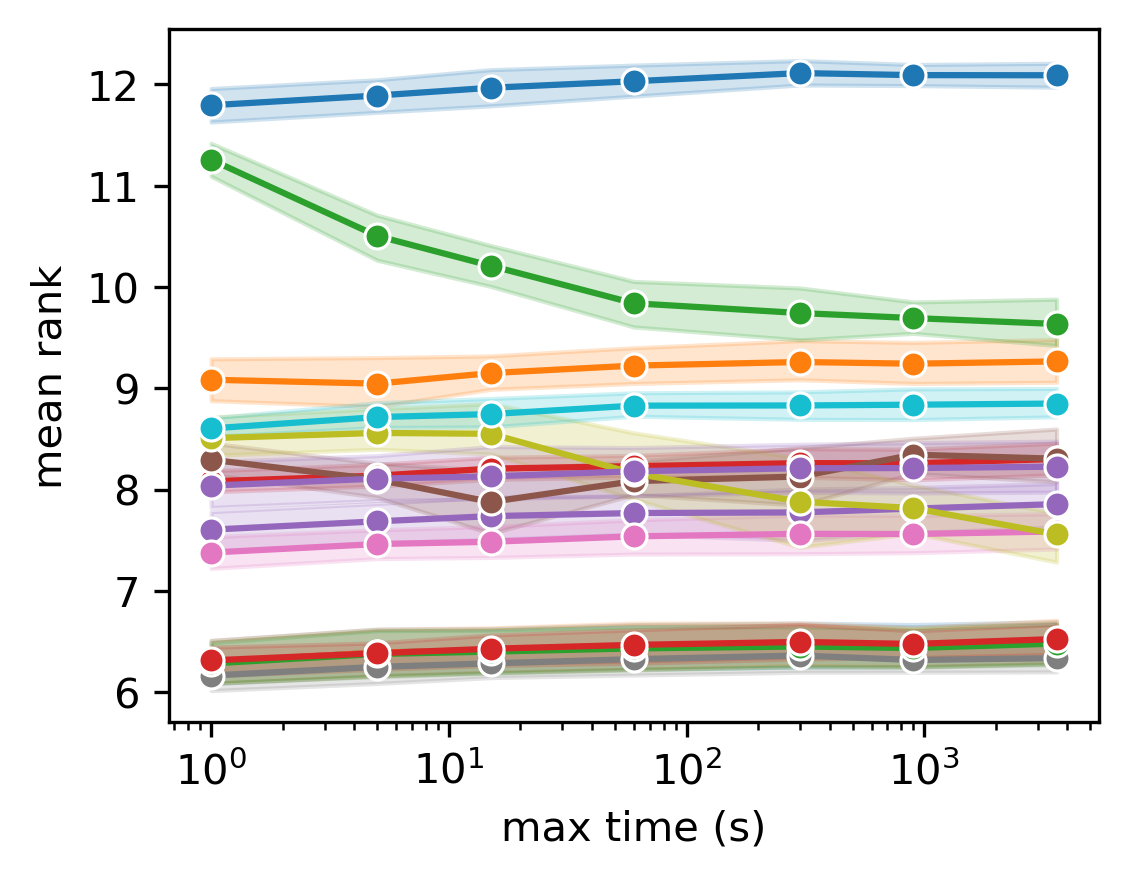

In [34]:
# ax = sns.lineplot(data=average_ranks, x="max_time", y="mean_rank", hue="model", errorbar="sd", marker="o")
plt.figure(figsize=(4, 3), dpi=300)
ax = sns.lineplot(data=remove_device_from_frame(average_ranks), x="max_time", y="mean_rank", hue="model", marker="o", palette=color_mapping)
ax.set_xscale("log")
#sns.move_legend(ax, (1.01, 0))
ax.set_ylabel("mean rank")
ax.set_xlabel("max time (s)")
plt.legend(loc=(1.1 , .3))
legend = ax.get_legend()
legend.remove()
plt.savefig("figures/rank_over_time_validation.pdf", bbox_inches="tight")

NameError: name 'with_tuning' is not defined

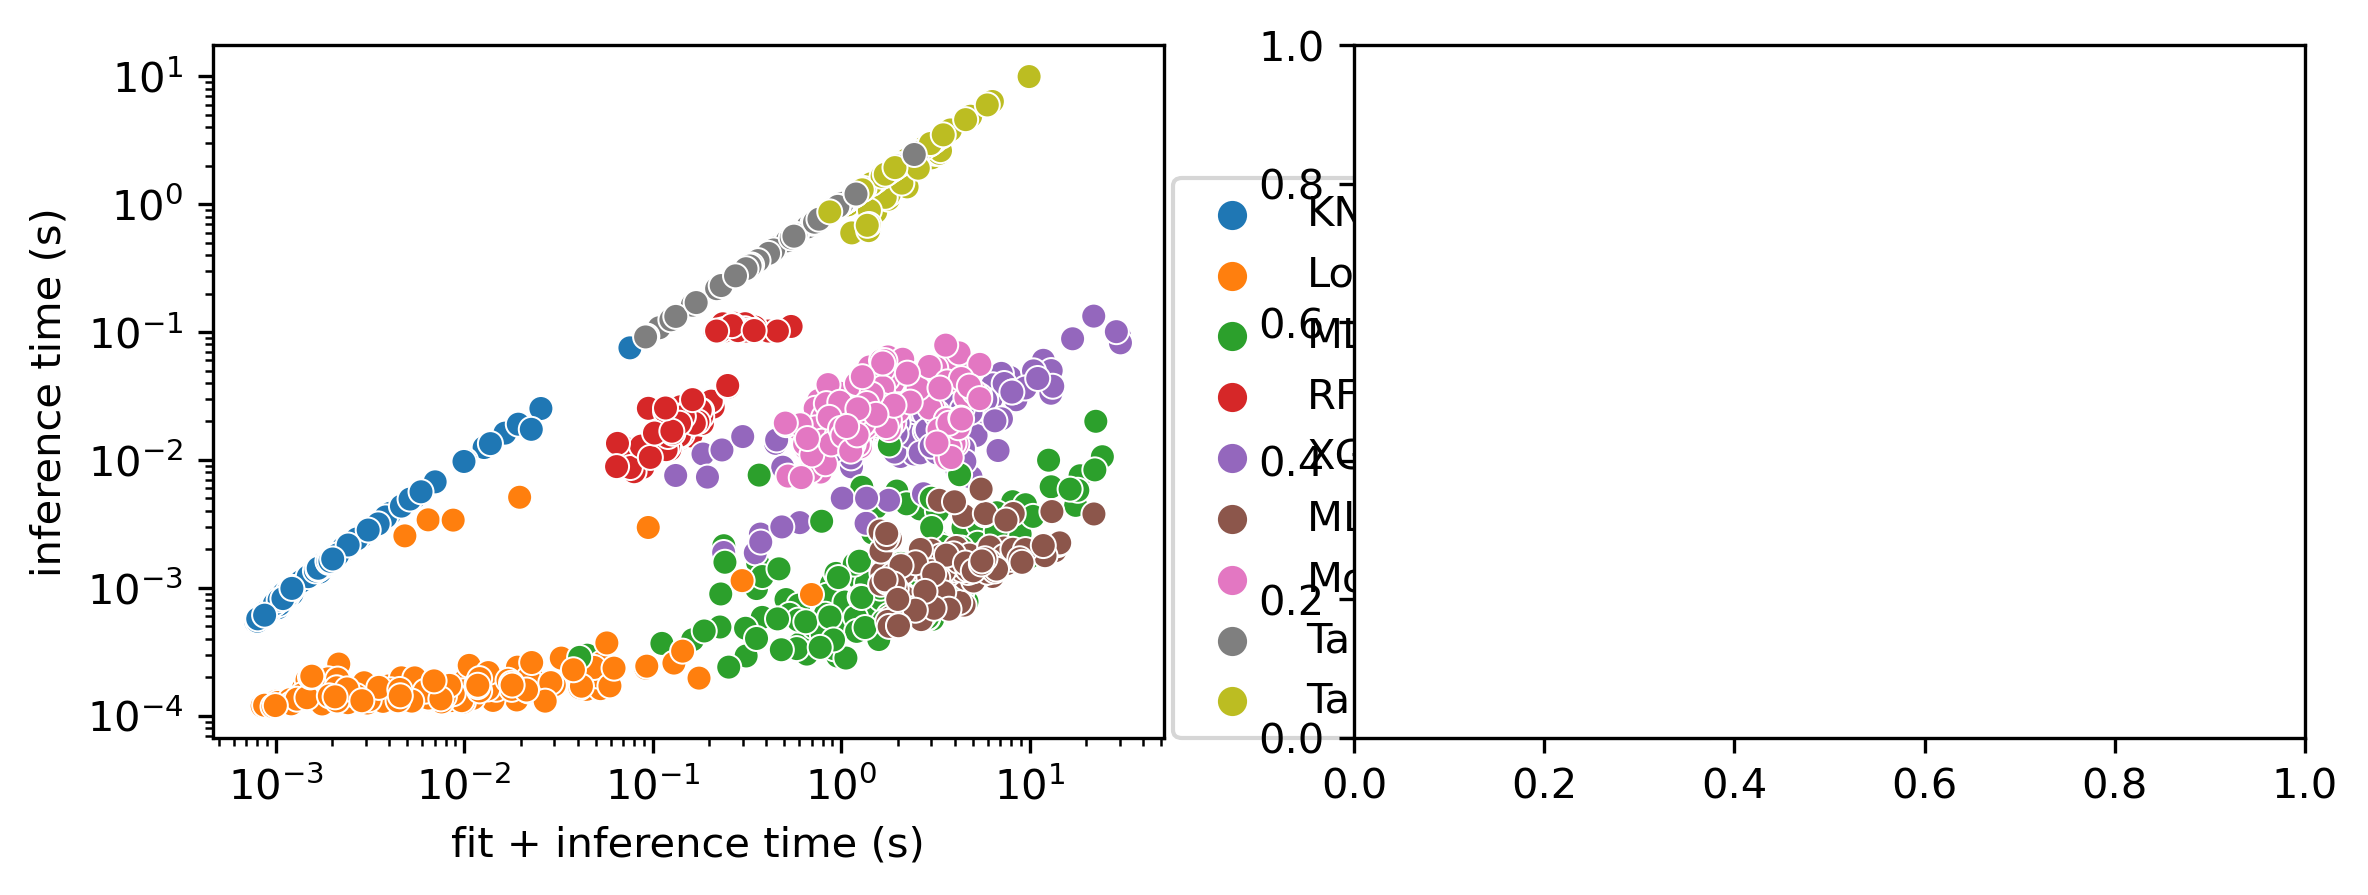

In [120]:

combined_best = pd.concat([best_tuned, untuned])
combined_best = combined_best[~combined_best.model.isin(["tabpfn_post_mlflow", "distill_tabpfn_scaled"])].copy()
max_time = combined_best.max_time.max()

fig, axes = plt.subplots(1, 2, figsize=(9, 3), dpi=300)

combined_best['fit_and_predict_time'] = combined_best['fit_time'] + combined_best['inference_time']

#sns.scatterplot(data=combined_best, y="inference_time", x="fit_and_predict_time", hue="model", ax=axes[0], hue_order=["MotherNet", "TabPFN GPU", 'TabPFN-distill GPU', 'XGBoost', 'MotherNet GPU', "KNN", "LogReg", "RF", "MLP"])
sns.scatterplot(data=combined_best, y="inference_time", x="fit_and_predict_time", hue="model", ax=axes[0])
axes[0].set_xscale("log")
axes[0].set_yscale("log")
axes[0].set_xlabel("fit + inference time (s)")
axes[0].set_ylabel("inference time (s)")
legend = axes[0].legend(loc=(1.01, 0))
#sns.move_legend(axes[0], (1.01, 0))

combined_best['fit_predict_tuning'] = combined_best['fit_and_predict_time'].copy()
#with_tuning = with_tuning[with_tuning.model.isin(["MotherNet", "TabPFN GPU", 'TabPFN-distill GPU', 'XGBoost', 'MotherNet GPU'])]
combined_best.fit_predict_tuning[with_tuning.model == "XGBoost"] = combined_best.fit_and_predict_time[with_tuning.model == "XGBoost"] + max_time
combined_best.fit_predict_tuning[with_tuning.model == "MLP"] = combined_best.fit_and_predict_time[with_tuning.model == "MLP"] + max_time
combined_best.fit_predict_tuning[with_tuning.model == "KNN"] = combined_best.fit_and_predict_time[with_tuning.model == "KNN"] + max_time
combined_best.fit_predict_tuning[with_tuning.model == "RF"] = combined_best.fit_and_predict_time[with_tuning.model == "RF"] + max_time
combined_best.fit_predict_tuning[with_tuning.model == "LogReg"] = combined_best.fit_and_predict_time[with_tuning.model == "LogReg"] + max_time


#sns.scatterplot(data=with_tuning, y="inference_time", x="fit_and_predict_time", hue="model", ax=axes[1], hue_order=["MotherNet", "TabPFN GPU", 'TabPFN-distill GPU', 'XGBoost', 'MotherNet GPU'])
sns.scatterplot(data=combined_best, y="inference_time", x="fit_predict_tuning", hue="model", ax=axes[1])
axes[1].set_xscale("log")
axes[1].set_yscale("log")
axes[1].set_xlabel("fit + inference time + tuning (s)")
axes[1].set_ylabel("inference time (s)")

axes[1].legend().remove()
plt.tight_layout()
plt.savefig("timing_comparison_GPU_two_panels_gpu_mlp_utc_validation.pdf")

In [58]:
fit_times = combined_best.set_index(['dataset', 'model']).unstack("model").fit_time
fit_times.divide(fit_times['XGBoost'], axis='rows').mean()

fit_and_predict_time = combined_best.set_index(['dataset', 'model']).unstack("model").fit_and_predict_time
fit_and_predict_time.divide(fit_and_predict_time['XGBoost'], axis='rows').mean()

model
KNN                0.001681
LogReg             0.007554
MLP                1.881840
MotherNet          1.384605
RF                 0.151986
TabPFN (ours)      1.072932
TabPFN GPU         0.593634
UTC-Distill GPU    2.780388
XGBoost            1.000000
dtype: float64

In [59]:
combined_best.columns

Index(['dataset', 'model', 'max_time', 'mean_metric', 'fit_time',
       'inference_time', 'fit_and_predict_time', 'fit_predict_tuning'],
      dtype='object')

In [60]:
results_df

,dataset,model,mean_metric,split,max_time,best,fit_time,inference_time
0,breast-cancer,KNN,0.661028,1,1,{'n_neighbors': 13},0.000223,0.001148
1,breast-cancer,KNN,0.687982,2,1,{'n_neighbors': 13},0.000218,0.001148
2,breast-cancer,KNN,0.639348,3,1,{'n_neighbors': 14},0.000214,0.001040
3,breast-cancer,KNN,0.697394,4,1,{'n_neighbors': 14},0.000223,0.001092
4,breast-cancer,KNN,0.687948,5,1,{'n_neighbors': 11},0.000226,0.001065
...,...,...,...,...,...,...,...,...
33520,titanic,MotherNet,0.870563,1,1,NaN,1.247649,0.022078
33521,titanic,MotherNet,0.875878,2,1,NaN,1.227568,0.022688
33522,titanic,MotherNet,0.870438,3,1,NaN,1.199560,0.024406
33523,titanic,MotherNet,0.881003,4,1,NaN,1.209380,0.023539


In [53]:
bla = results_df.groupby(["model", "dataset", "max_time"])['mean_metric'].mean().reset_index()

In [54]:
bla.model.unique()

array(['KNN', 'LogReg', 'MLP', 'MotherNet', 'RF', 'TabPFN (ours)',
       'TabPFN GPU', 'UTC-Distill GPU', 'XGBoost'], dtype=object)

In [55]:
filtered = bla[bla.model.isin(["MotherNet", "TabPFN (ours)", "XGBoost", 'UTC-Distill GPU'])]

In [56]:
with_max_time = filtered.groupby(["model", "dataset"]).max().reset_index()

In [57]:
compare = with_max_time.pivot(index="dataset", columns="model", values="mean_metric")

In [60]:
#different = compare[np.abs((compare["TabPFN (ours)"] - compare["XGBoost"])) > 0.1]
different = compare[np.abs((compare[ 'UTC-Distill GPU'] - compare["MotherNet"])) > 0.1]

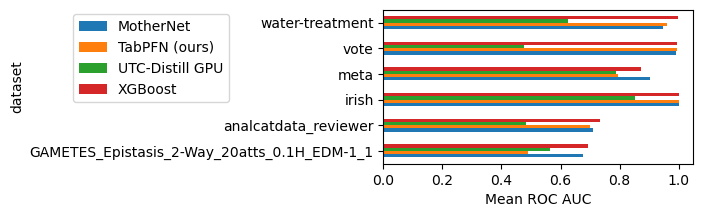

In [61]:
#plt.figure(figsize=(5, 15))
plt.figure(figsize=(4, 2))
different.plot.barh(ax=plt.gca())
plt.legend(loc=(-1, .4))
plt.xlabel("Mean ROC AUC")
plt.savefig("figures/validation_set_differences.pdf", dpi=300, bbox_inches="tight")

In [74]:
different

model,TabPFN (ours),XGBoost
dataset,,
GAMETES_Epistasis_2-Way_20atts_0.1H_EDM-1_1,0.488806,0.692342
monks-problems-1,0.859123,1.000000
parity5_plus_5,0.466570,0.991805
schizo,0.619223,0.795779
teachingAssistant,0.687879,0.939853
